<a href="https://colab.research.google.com/github/viksit-siddhant/Deep-Dreams/blob/main/deep_dreams2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import urllib.request
import tarfile
import zipfile

def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

def maybe_download_and_extract(url, download_dir):
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)
    if not os.path.exists(file_path):
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

In [ ]:
import numpy as np
import tensorflow as tf
data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = "inception/5h/"
path_graph_def = "tensorflow_inception_graph.pb"


def maybe_download():
    print("Downloading Inception 5h Model ...")
    maybe_download_and_extract(url=data_url, download_dir=data_dir)

class Inception5h:
    tensor_name_input_image = "input:0"
    layer_names = ['conv2d0', 'conv2d1', 'conv2d2',
                   'mixed3a', 'mixed3b',
                   'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
                   'mixed5a', 'mixed5b']

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            path = os.path.join(data_dir, path_graph_def)
            with tf.gfile.FastGFile(path, 'rb') as file:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(file.read())
                tf.import_graph_def(graph_def, name='')
            self.input = self.graph.get_tensor_by_name(self.tensor_name_input_image)
            self.layer_tensors = [self.graph.get_tensor_by_name(name + ":0") for name in self.layer_names]

    def create_feed_dict(self, image=None):
        image = np.expand_dims(image, axis=0)
        feed_dict = {self.tensor_name_input_image: image}

        return feed_dict

    def get_gradient(self, tensor):
        with self.graph.as_default():
            tensor = tf.square(tensor)

            tensor_mean = tf.reduce_mean(tensor)

            gradient = tf.gradients(tensor_mean, self.input)[0]

        return gradient

In [ ]:
!wget https://www.dropbox.com/sh/g91hjgr30owfdf6/AAAMxg5_0ymSZO5-qNHDrpOVa?dl=0

--2019-07-21 15:47:15--  https://www.dropbox.com/sh/g91hjgr30owfdf6/AAAMxg5_0ymSZO5-qNHDrpOVa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/g91hjgr30owfdf6/AAAMxg5_0ymSZO5-qNHDrpOVa [following]
--2019-07-21 15:47:16--  https://www.dropbox.com/sh/raw/g91hjgr30owfdf6/AAAMxg5_0ymSZO5-qNHDrpOVa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfd04f47e7884affdbaf943473c.dl.dropboxusercontent.com/zip_by_token_key?key=AlG75_9DnBtI9JgtgMduAHKc0L1MTNDZXqFbdlnHdkF2s1Q7DSM08qKU28mFKdRxtm_L-Jhk63qCOjfDwpkvXzpr8Dw4byTYhvnU6f82iVUh-Mja-iiI2t-cnWr8uF2_KiP3p1mv3Wxx5msPuwmVQwzAe2XfUexCBRxtJq34WHmc98bVJDHzzdelUFn06exsyjfELK1vmNYNmU6hStQX6oWZKQpmzmeQ7yfa-BUdJKcGfA [following]
--2019-07-21 15:47:16--  https://ucfd04f47e7884affdbaf943

In [ ]:
!unzip "AAAMxg5_0ymSZO5-qNHDrpOVa?dl=0"

Archive:  AAAMxg5_0ymSZO5-qNHDrpOVa?dl=0
mapname:  conversion of  failed
  inflating: 5h/tensorflow_inception_graph-ORIGINAL.pb  
  inflating: 5h/imagenet_comp_graph_label_strings.txt  
  inflating: 5h/LICENSE              
  inflating: 5h/tensorflow_inception_graph.pb  
  inflating: 5h/inception5h.zip      

1 archive had fatal errors.


In [ ]:
!mkdir inception

In [ ]:
!mv 5h inception/ 

In [ ]:
import matplotlib.pyplot as plt
import random
import math
import PIL.Image
from scipy.ndimage.filters import gaussian_filter

model = Inception5h()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
session = tf.Session(graph=model.graph,
                     config=tf.ConfigProto(gpu_options=gpu_options))


def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

def save_image(image, filename):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

def plot_image(image):
    if False:
        image = np.clip(image/255.0, 0.0, 1.0)
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        image = np.clip(image, 0.0, 255.0)
        image = image.astype(np.uint8)
        plt.imshow(image, interpolation='lanczos')
        plt.show()

def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm


def plot_gradient(gradient):
    gradient_normalized = normalize_image(gradient)
    plt.imshow(gradient_normalized, interpolation='bilinear')
    plt.show()

def resize_image(image, size=None, factor=None):
    if factor is not None:
        size = np.array(image.shape[0:2]) * factor
        size = size.astype(int)
    else:
        size = size[0:2]
    size = tuple(reversed(size))

    img = np.clip(image, 0.0, 255.0)
    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    img_resized = np.float32(img_resized)

    return img_resized

def get_tile_size(num_pixels, tile_size=400):
    num_tiles = int(round(num_pixels / tile_size))
    num_tiles = max(1, num_tiles)
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    return actual_tile_size


def tiled_gradient(gradient, image, tile_size=400):
    grad = np.zeros_like(image)
    x_max, y_max, _ = image.shape
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    x_tile_size4 = x_tile_size // 4
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    y_tile_size4 = y_tile_size // 4
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)

    while x_start < x_max:
        x_end = x_start + x_tile_size
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            y_end = y_start + y_tile_size
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]
            feed_dict = model.create_feed_dict(image=img_tile)
            g = session.run(gradient, feed_dict=feed_dict)
            g /= (np.std(g) + 1e-8)
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            y_start = y_end

        x_start = x_end

    return grad


def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    img = image.copy()

    print("Processing image: ")

    gradient = model.get_gradient(layer_tensor)

    for i in range(num_iterations):
        grad = tiled_gradient(gradient=gradient, image=img)
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        img += grad * step_size_scaled

        if show_gradient:
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))
            plot_gradient(grad)
        else:
            print(". ", end="")
    return img


def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    if num_repeats > 0:
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)

        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)

        img_upscaled = resize_image(image=img_result, size=image.shape)
        image = blend * image + (1.0 - blend) * img_upscaled
    print("Recursive level:", num_repeats)

    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)

    return img_result

W0721 15:48:07.282991 140524633462656 deprecation.py:323] From <ipython-input-2-6f7d4fb776ec>:23: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


In [1]:
!wget https://www.dropbox.com/s/gnpa5khpevepcwf/wallpaper.jpg?dl=0

--2022-09-29 13:14:36--  https://www.dropbox.com/s/gnpa5khpevepcwf/wallpaper.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/gnpa5khpevepcwf/wallpaper.jpg [following]
--2022-09-29 13:14:37--  https://www.dropbox.com/s/raw/gnpa5khpevepcwf/wallpaper.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3bf3baef465ffd5bb3ee074e3a.dl.dropboxusercontent.com/cd/0/inline/Bt2sgUTgb8J66TWPiQlo_6mHmSxbJDYxkdtdhbzeEzn0phUc0pPODp0xrJc5Nedyd7RBtnvBgLr-xEHOF3czJpzrRCMeops16UtBOV3prDiZV-WyW0HuohS8pwJTSDuwg1OhhSx5MGTnIIxOtED2K2hJVyAxUOv8z0c-nxUWEKRG1A/file# [following]
--2022-09-29 13:14:37--  https://uc3bf3baef465ffd5bb3ee074e3a.dl.dropboxusercontent.com/cd/0/inline/Bt2sgUTgb8J66TWPiQlo_6mHmSxbJDYxkdtdhbzeEzn0phUc0pPODp0xrJc5Nedyd7RBtnvB

In [ ]:
layer_tensor = model.layer_tensors[4]
file_name = 'wallpaper.jpg?dl=0'
img_result = load_image(filename='{}'.format(file_name))
print(img_result.shape)
img_result = recursive_optimize(layer_tensor=layer_tensor, image=img_result,
                 num_iterations=30, step_size=1.0, rescale_factor=0.6,
                 num_repeats=10, blend=0.2)

img_result = np.clip(img_result, 0.0, 255.0)
img_result = img_result.astype(np.uint8)
result = PIL.Image.fromarray(img_result, mode='RGB')
result.save('dream_image_out.jpg')

(1800, 2880, 3)
Recursive level: 0
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 1
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 2
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 3
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 4
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 5
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 6
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 7
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 8
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recursive level: 9
Processing image: 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Recu

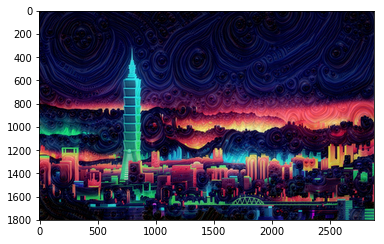

In [ ]:
plot_image(img_result)